In [ ]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import zipfile
import random
import math
import string

import open_clip
from PIL import Image
from datasets import load_dataset
from transformers import AutoTokenizer, BartForConditionalGeneration
from huggingface_hub import hf_hub_download

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW

from tqdm.auto import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
DRIVE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/WOA7015_Advanced_ML/AA"
WEIGHT_FOLDER = DRIVE_FOLDER + "/Weights"

if not os.path.exists(WEIGHT_FOLDER):
    os.makedirs(WEIGHT_FOLDER)

BASE_NAME = "med_vqa_model_1.pth"

Mounted at /content/drive


# Dataset

In [ ]:
REPO_ID = "BoKelvin/SLAKE"
EXTRACT_PATH = "./slake_extract"

print("Downloading images from Hugging Face...")
try:
    img_zip_path = hf_hub_download(repo_id=REPO_ID, filename="imgs.zip", repo_type="dataset")
except Exception as e:
    print(f"Download failed: {e}")

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    print("Extracting images...")
    with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print("Images already extracted.")

if os.path.exists(os.path.join(EXTRACT_PATH, 'imgs')):
    IMG_DIR = os.path.join(EXTRACT_PATH, 'imgs')
    print(f"Found subfolder 'imgs'. Setting IMG_DIR to: {IMG_DIR}")
else:
    IMG_DIR = EXTRACT_PATH
    print(f"No subfolder found. Setting IMG_DIR to: {IMG_DIR}")

test_path = os.path.join(IMG_DIR, 'xmlab0', 'source.jpg')
if os.path.exists(test_path):
    print("SUCCESS: Verified image path structure.")
else:
    print(f"WARNING: Could not find test image at {test_path}.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


imgs.zip:   0%|          | 0.00/212M [00:00<?, ?B/s]

Extracting images...
Extraction complete.
Found subfolder 'imgs'. Setting IMG_DIR to: ./slake_extract/imgs
SUCCESS: Verified image path structure.


In [ ]:
BIOMEDCLIP_ID = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
BIOBART_ID = 'GanjinZero/biobart-base'

print("Loading BioMedCLIP transforms...")
_, _, preprocess_img = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)

print("Loading BioBART tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BIOBART_ID)

Loading BioMedCLIP transforms...


open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Loading BioBART tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128

def transform_fn(batch):
    images = []
    keep_indices = []

    for i, img_name in enumerate(batch['img_name']):
        full_path = os.path.join(IMG_DIR, img_name)
        try:
            image = Image.open(full_path).convert("RGB")
            images.append(preprocess_img(image))
            keep_indices.append(i)
        except (FileNotFoundError, OSError):
            print(f"WARNING: Skipping missing image {img_name}")
            continue

    # Make sure these lists contain data for loaded images only
    valid_questions = [batch['question'][i] for i in keep_indices]
    valid_answers = [str(batch['answer'][i]) for i in keep_indices]
    valid_types = [batch['answer_type'][i] for i in keep_indices]

    text_inputs = tokenizer(
        valid_questions,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    target_inputs = tokenizer(
        valid_answers,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = target_inputs["input_ids"]
    # Ignore padding tokens (prevent prediction of text padding)
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "pixel_values": images,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "labels": labels,
        "answer_text": valid_answers,
        "answer_type": valid_types
    }

In [ ]:
def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    # Batch can't contain strings, convert to list
    answer_texts = [item['answer_text'] for item in batch]
    answer_types = [item['answer_type'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'answer_text': answer_texts,
        'answer_type': answer_types
    }

In [ ]:
print("Loading BoKelvin/SLAKE dataset...")
dataset = load_dataset(REPO_ID)
dataset = dataset.filter(lambda example: example['q_lang'] == 'en')
dataset = dataset.with_transform(transform_fn)

train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
train_subset = Subset(dataset['train'], range(0, 200))
train_subset_loader = DataLoader(train_subset, batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset['validation'], batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset['test'], batch_size=32, collate_fn=custom_collate_fn, num_workers=2, pin_memory=True)

print("Data Setup Complete.")

Loading BoKelvin/SLAKE dataset...


README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9835 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9835 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2099 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2094 [00:00<?, ? examples/s]

Data Setup Complete.


# Model (BioMedCLIP + BioBART)

In [ ]:
class MedVQAModel(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device

        # Vision Encoder (BioMedCLIP)
        clip_model, _, _ = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)
        self.visual_encoder = clip_model.visual
        self.visual_encoder.requires_grad_(False)

        # Text Decoder (BioBART)
        self.decoder = BartForConditionalGeneration.from_pretrained(BIOBART_ID)
        self.decoder_dim = self.decoder.config.d_model # 768

        # Projector
        self.projector = nn.Sequential(
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(2048, self.decoder_dim)
        )

        # Modality type embeddings
        self.image_type_embed = nn.Parameter(torch.randn(1, 1, self.decoder_dim) * 0.02)
        self.text_type_embed = nn.Parameter(torch.randn(1, 1, self.decoder_dim) * 0.02)

    # Helper to safely get scaled embeddings
    def get_text_embeddings(self, input_ids):
        # Access the shared embedding layer
        embed_tokens = self.decoder.model.shared(input_ids)

        # Scale embeddings if required by the config
        if getattr(self.decoder.config, "scale_embedding", False):
            embed_scale = math.sqrt(self.decoder.config.d_model)
            embed_tokens = embed_tokens * embed_scale

        return embed_tokens

    def prepare_multimodal_inputs(self, pixel_values, input_ids, attention_mask):
        # Encode image
        with torch.no_grad():
            image_embeds = self.visual_encoder(pixel_values) # (Batch, 512)

        # Project image
        image_embeds = self.projector(image_embeds).unsqueeze(1) # (Batch, 1, 768)

        # Add image type embedding
        image_embeds = image_embeds + self.image_type_embed

        # Encode text
        inputs_embeds = self.get_text_embeddings(input_ids)

        # Add text type embedding
        inputs_embeds = inputs_embeds + self.text_type_embed

        # Concatenate (image + text)
        combined_embeds = torch.cat([image_embeds, inputs_embeds], dim=1)

        # Extend mask (cater for concat)
        ones = torch.ones((input_ids.shape[0], 1), device=input_ids.device)
        combined_mask = torch.cat([ones, attention_mask], dim=1)

        return combined_embeds, combined_mask

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
        # Prepare inputs
        combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

        # Decode
        outputs = self.decoder(
            inputs_embeds=combined_embeds,
            attention_mask=combined_mask,
            labels=labels
        )

        return outputs

    def generate(self, pixel_values, input_ids, attention_mask, max_new_tokens=20):
        with torch.no_grad():
            # Prepare inputs
            combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

            # Generate
            return self.decoder.generate(
                inputs_embeds=combined_embeds,
                attention_mask=combined_mask,
                max_new_tokens=max_new_tokens,
                num_beams=3
            )

# Train and Evaluate

In [ ]:
# Lowercase, remove punctuation, clean whitespace
def normalize_text(text):
    text = text.lower()
    text = "".join([c for c in text if c not in string.punctuation])
    return " ".join(text.split())

def evaluate(model, loader, tokenizer, device, desc="Evaluating"):
    model.eval()

    correct_open = 0; total_open = 0
    correct_closed = 0; total_closed = 0
    total_loss = 0
    bleu_open = []; bleu_closed = []

    progress_bar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values, input_ids, mask, labels=labels)
            total_loss += outputs.loss.item()

            generated_ids = model.generate(pixel_values, input_ids, mask, max_new_tokens=20)
            pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            ref_texts = batch['answer_text']
            types = batch['answer_type']

            for pred, ref, ans_type in zip(pred_texts, ref_texts, types):
                pred_clean = normalize_text(pred)
                ref_clean = normalize_text(ref)

                # Accuracy (checks for entire string match)
                is_correct = (pred_clean == ref_clean)

                # BLEU (1-gram)
                ref_tokens = ref_clean.split()
                pred_tokens = pred_clean.split()
                if not pred_tokens: pred_tokens = [""]
                score = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)

                if ans_type == 'CLOSED':
                    total_closed += 1
                    bleu_closed.append(score)
                    if is_correct: correct_closed += 1
                else:
                    total_open += 1
                    bleu_open.append(score)
                    if is_correct: correct_open += 1

    avg_loss = total_loss / len(loader)

    acc_open = correct_open / total_open if total_open > 0 else 0
    acc_closed = correct_closed / total_closed if total_closed > 0 else 0

    total_samples = total_open + total_closed
    acc_overall = (correct_open + correct_closed) / total_samples if total_samples > 0 else 0

    avg_bleu_open = sum(bleu_open) / len(bleu_open) if bleu_open else 0
    avg_bleu_closed = sum(bleu_closed) / len(bleu_closed) if bleu_closed else 0
    all_bleu = bleu_open + bleu_closed
    avg_bleu_overall = sum(all_bleu) / len(all_bleu) if all_bleu else 0

    return {
        "loss": avg_loss,
        "acc_open": acc_open,
        "acc_closed": acc_closed,
        "acc_overall": acc_overall,
        "bleu_open": avg_bleu_open,
        "bleu_closed": avg_bleu_closed,
        "bleu_overall": avg_bleu_overall
    }

In [ ]:
def train_and_validate(model, train_loader, val_loader, train_subset_loader, optimizer, tokenizer, device, num_epochs):
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [],  "val_acc": []
    }

    best_val_loss = float('inf')
    best_val_overall_acc = 0.0
    best_val_open_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values, input_ids, mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        val_res = evaluate(model, val_loader, tokenizer, device, desc="Validating")

        # Evaluate on subset of train set (whole train set would be slow)
        train_res = evaluate(model, train_subset_loader, tokenizer, device, desc="Checking Train Acc")

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_res['loss'])
        history["train_acc"].append(train_res['acc_overall'])
        history["val_acc"].append(val_res['acc_overall'])

        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {val_res['loss']:.4f}")
        print(f"  Train Acc:  {train_res['acc_overall']:.4f} | Val Acc:  {val_res['acc_overall']:.4f}")
        print(f"  Val BLEU-1: {val_res['bleu_overall']:.4f}")

        if val_res['loss'] < best_val_loss:
            best_val_loss = val_res['loss']
            save_name = f"loss_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Val Loss: {best_val_loss:.4f})")

        if val_res['acc_overall'] > best_val_overall_acc:
            best_val_overall_acc = val_res['acc_overall']
            save_name = f"acc_overall_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Overall Acc: {best_val_overall_acc:.4f})")

        if val_res['acc_open'] > best_val_open_acc:
            best_val_open_acc = val_res['acc_open']
            save_name = f"acc_open_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Open Acc: {best_val_open_acc:.4f})")

    print("\nTraining Complete.")
    return history

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MedVQAModel(device).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

In [ ]:
history = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_subset_loader=train_subset_loader,
    optimizer=optimizer,
    tokenizer=tokenizer,
    device=device,
    num_epochs=15,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

Starting training for 15 epochs...


Epoch 1/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.9610 | Val Loss: 0.3781
  Train Acc:  0.5700 | Val Acc:  0.5546
  Val BLEU-1: 0.5859
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.3781)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.5546)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.5515)


Epoch 2/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.3700 | Val Loss: 0.2758
  Train Acc:  0.6650 | Val Acc:  0.6524
  Val BLEU-1: 0.6837
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2758)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.6524)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6323)


Epoch 3/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2825 | Val Loss: 0.2286
  Train Acc:  0.6600 | Val Acc:  0.6752
  Val BLEU-1: 0.7097
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2286)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.6752)


Epoch 4/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2315 | Val Loss: 0.1980
  Train Acc:  0.7300 | Val Acc:  0.7028
  Val BLEU-1: 0.7341
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1980)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7028)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6719)


Epoch 5/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2080 | Val Loss: 0.2030
  Train Acc:  0.7200 | Val Acc:  0.7493
  Val BLEU-1: 0.7750
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7493)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7132)


Epoch 6/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1805 | Val Loss: 0.1775
  Train Acc:  0.7850 | Val Acc:  0.7597
  Val BLEU-1: 0.7882
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1775)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7597)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7242)


Epoch 7/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1721 | Val Loss: 0.1781
  Train Acc:  0.8250 | Val Acc:  0.7711
  Val BLEU-1: 0.7922
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7711)


Epoch 8/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1498 | Val Loss: 0.1717
  Train Acc:  0.7800 | Val Acc:  0.7645
  Val BLEU-1: 0.7853
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1717)


Epoch 9/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1446 | Val Loss: 0.1517
  Train Acc:  0.8600 | Val Acc:  0.8120
  Val BLEU-1: 0.8415
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1517)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.8120)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7908)


Epoch 10/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1519 | Val Loss: 0.1787
  Train Acc:  0.8050 | Val Acc:  0.8015
  Val BLEU-1: 0.8238


Epoch 11/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1299 | Val Loss: 0.1841
  Train Acc:  0.8300 | Val Acc:  0.7664
  Val BLEU-1: 0.7982


Epoch 12/15:   0%|          | 0/308 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f642177af20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1200 | Val Loss: 0.1812
  Train Acc:  0.8200 | Val Acc:  0.8063
  Val BLEU-1: 0.8387


Epoch 13/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.1074 | Val Loss: 0.1851
  Train Acc:  0.8500 | Val Acc:  0.7825
  Val BLEU-1: 0.8137


Epoch 14/15:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def plot_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.title('Overall Accuracy vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_curves(history)

# Evaluate with Test Set

In [ ]:
best_weight_path = os.path.join(WEIGHT_FOLDER, f"acc_overall_best_{BASE_NAME}")

print(f"Loading best weights from: {best_weight_path}")

if os.path.exists(best_weight_path):
    checkpoint = torch.load(best_weight_path, map_location=device)
    model.load_state_dict(checkpoint)
    print("Best weights loaded successfully.")
else:
    print(f"Warning: File not found at {best_weight_path}. Using current model weights.")

Loading best weights from: /content/drive/MyDrive/Colab Notebooks/WOA7015_Advanced_ML/AA/Weights/acc_overall_best_med_vqa_model_1.pth
Best weights loaded successfully.


In [ ]:
print("Starting evaluation on Test Set...")
results = evaluate(model, test_loader, tokenizer, device)

print("\n" + "="*40)
print("FINAL EVALUATION RESULTS")
print("="*40)
print(f"OVERALL Accuracy: {results['acc_overall']:.4f}")
print(f"OVERALL BLEU-1:   {results['bleu_overall']:.4f}")
print("-" * 40)
print(f"CLOSED Questions:")
print(f"  Accuracy:       {results['acc_closed']:.4f}")
print(f"  BLEU-1:         {results['bleu_closed']:.4f}")
print("-" * 40)
print(f"OPEN Questions:")
print(f"  Accuracy:       {results['acc_open']:.4f}")
print(f"  BLEU-1:         {results['bleu_open']:.4f}")
print("="*40)

Starting evaluation on Test Set...


Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]


FINAL EVALUATION RESULTS
OVERALL Accuracy: 0.7936
OVERALL BLEU-1:   0.8250
----------------------------------------
CLOSED Questions:
  Accuracy:       0.8438
  BLEU-1:         0.8438
----------------------------------------
OPEN Questions:
  Accuracy:       0.7612
  BLEU-1:         0.8129


# Visualize Prediction

In [ ]:
raw_test_dataset = load_dataset(REPO_ID, split="test")
raw_test_dataset = raw_test_dataset.filter(lambda x: x['q_lang'] == 'en')

def visualize_prediction(index):
    item = raw_test_dataset[index]
    img_name = item['img_name']
    question = item['question']
    answer = str(item['answer'])

    img_path = os.path.join(IMG_DIR, img_name)

    try:
        pil_image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"Could not find image: {img_path}")
        return

    pixel_values = preprocess_img(pil_image).unsqueeze(0).to(device)

    text_inputs = tokenizer(
        question,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    ).to(device)

    input_ids = text_inputs["input_ids"]
    attention_mask = text_inputs["attention_mask"]

    # Run model
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, input_ids, attention_mask)

    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print(f"\n--- Sample {index} ---")
    print(f"Question:    {question}")
    print(f"Ground Truth: {answer}")
    print(f"Model Pred:   {prediction}")

    if prediction.strip().lower() == answer.strip().lower():
        print("Result:       ✅ MATCH")
    else:
        print("Result:       ❌ NOT MATCH")

    plt.figure(figsize=(8, 4))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"Type: {item['answer_type']}\nQ: {question}", fontsize=12, loc='left')
    plt.show()

Filter:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [ ]:
open_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'OPEN']
closed_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'CLOSED']

print(f"Found {len(open_indices)} OPEN questions and {len(closed_indices)} CLOSED questions.")

def show_samples_by_type(type_name, indices, num_to_show):
    print(f"\n{'='*40}")
    print(f"  VISUALIZING: {type_name} QUESTIONS")
    print(f"{'='*40}")

    # Pick random samples
    selected_indices = random.sample(indices, num_to_show)

    for idx in selected_indices:
        visualize_prediction(idx)

Found 645 OPEN questions and 416 CLOSED questions.



  VISUALIZING: CLOSED QUESTIONS

--- Sample 746 ---
Question:    Do the organs in the image exist in the abdomen?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


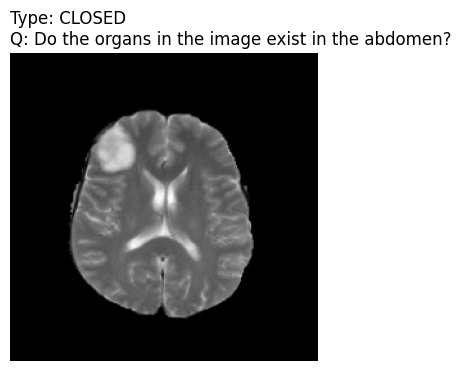


--- Sample 963 ---
Question:    Does the picture contain the organ which has the effect of sensing light?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


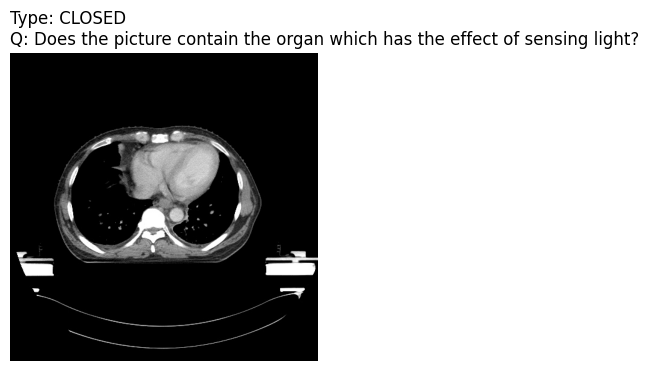


--- Sample 1054 ---
Question:    Which is the biggest in this image,lung,liver or heart?
Ground Truth: Lung
Model Pred:   Lung
Result:       ✅ MATCH


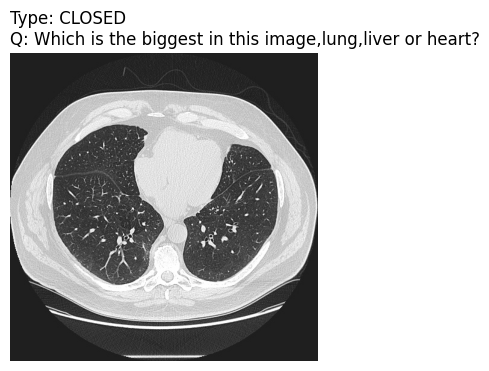


--- Sample 708 ---
Question:    Is this an MRI image with T1 weighted?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


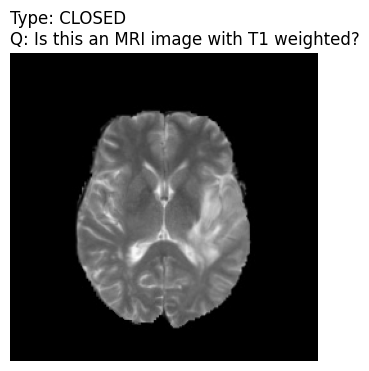


--- Sample 305 ---
Question:    Does the picture contain kidney?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


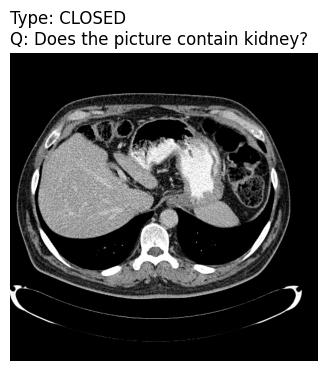


--- Sample 279 ---
Question:    Does the picture contain spleen?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


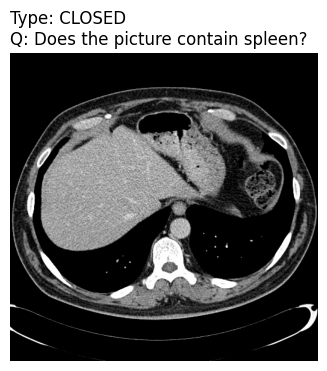


--- Sample 145 ---
Question:    Does the picture contain kidney?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


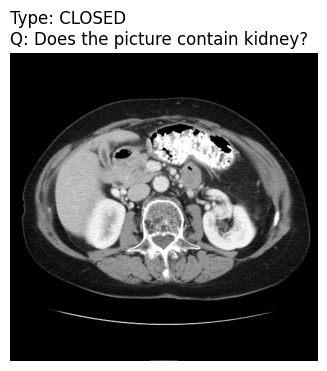


--- Sample 621 ---
Question:    Does the ears exist in this picture?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


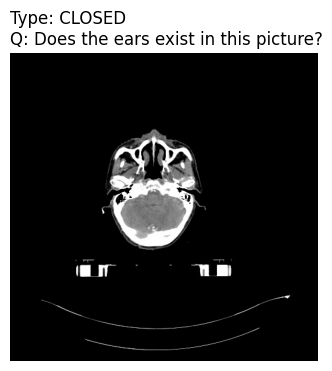


--- Sample 517 ---
Question:    Are there abnormalities in this image?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


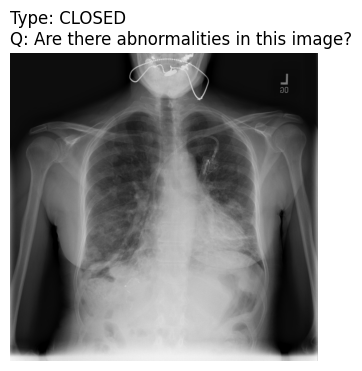


--- Sample 766 ---
Question:    Does the brain look abnormal?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


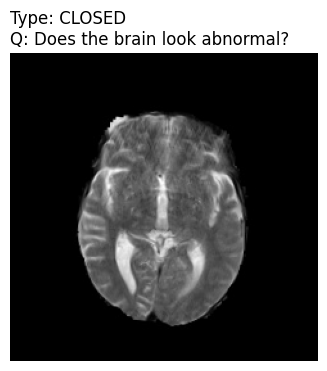

In [ ]:
show_samples_by_type("CLOSED", closed_indices, num_to_show=10)


  VISUALIZING: OPEN (Generative) QUESTIONS

--- Sample 460 ---
Question:    What color does the right lung show in the picture?
Ground Truth: Black
Model Pred:   Black
Result:       ✅ MATCH


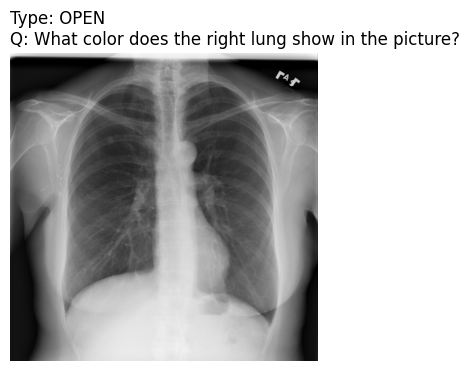


--- Sample 697 ---
Question:    What modality is used to take this image?
Ground Truth: MRI
Model Pred:   MRI
Result:       ✅ MATCH


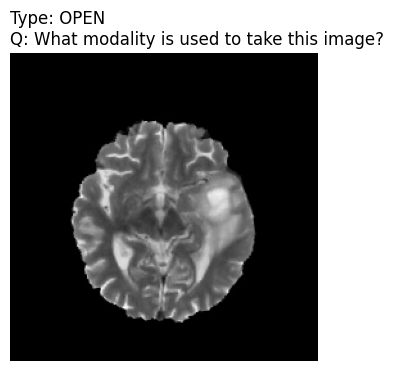


--- Sample 463 ---
Question:    What kind of symptoms will the disease on the upper right lung bring to the patient?
Ground Truth: Chest tightness, fatigue
Model Pred:   Chest tightness, fatigue
Result:       ✅ MATCH


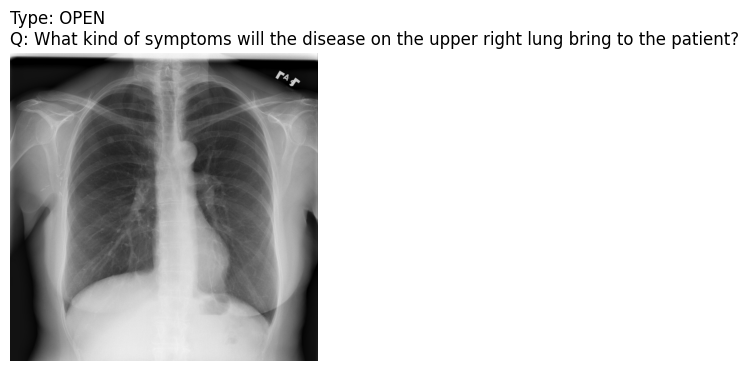


--- Sample 76 ---
Question:    Which part of the body does this image belong to?
Ground Truth: Chest
Model Pred:   Chest
Result:       ✅ MATCH


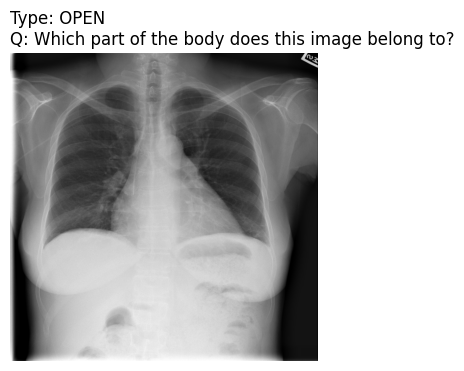


--- Sample 743 ---
Question:    How was this image taken?
Ground Truth: MRI
Model Pred:   MRI
Result:       ✅ MATCH


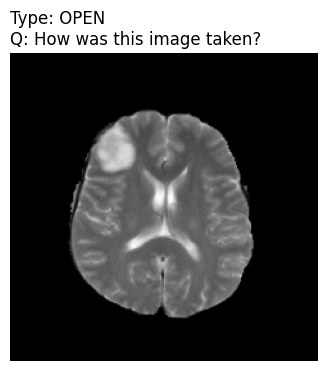


--- Sample 331 ---
Question:    What is the scanning plane of this image?
Ground Truth: Coronal Plane
Model Pred:   Coronal Plane
Result:       ✅ MATCH


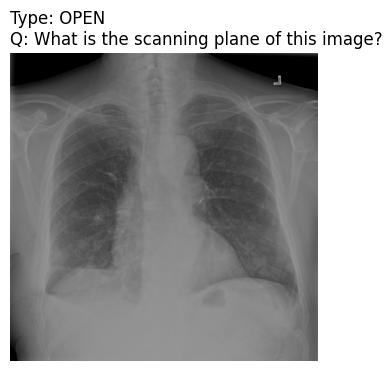


--- Sample 524 ---
Question:    Which organs/organ in the picture belong to the respiratory system?
Ground Truth: Lung
Model Pred:   Lung
Result:       ✅ MATCH


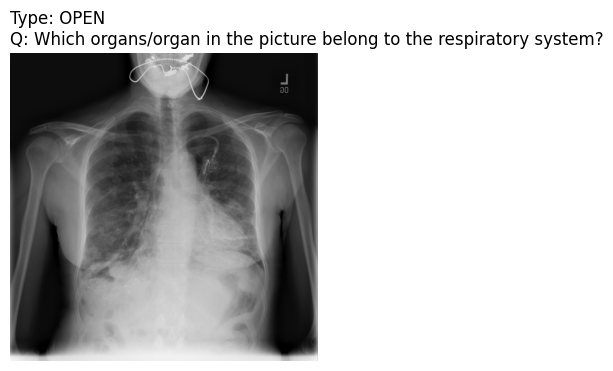


--- Sample 23 ---
Question:    What is the main organ in the image?
Ground Truth: Lung
Model Pred:   Lung
Result:       ✅ MATCH


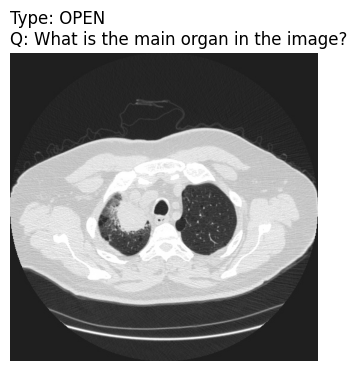


--- Sample 888 ---
Question:    Which is the kidney in this image?
Ground Truth: Symmetrical to the bottom spine
Model Pred:   Symmetrical to bottom spine
Result:       ❌ NOT MATCH


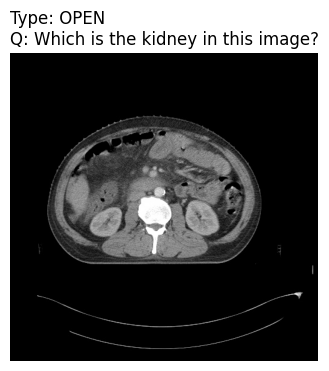


--- Sample 434 ---
Question:    Which organs/organ is part of the respiratory system in this image?
Ground Truth: Lung
Model Pred:   Lung
Result:       ✅ MATCH


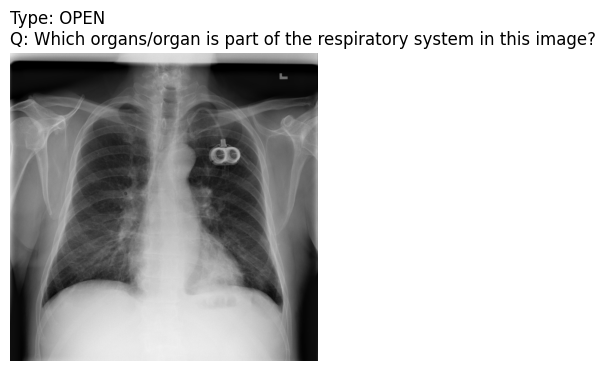

In [ ]:
show_samples_by_type("OPEN (Generative)", open_indices, num_to_show=10)